In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error,  r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [8]:
train_data = pd.read_csv('cvs_wg_pns_train.csv')
test_data = pd.read_csv('cvs_wg_pns_predict_on.csv')


In [113]:
# print("___________________________________________________________________________________________________________")
# print(train_data.head())
print("___________________________________________________________________________________________________________")
print(train_data.info())
# print("___________________________________________________________________________________________________________")
# print(train_data.describe())


___________________________________________________________________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18067 entries, 0 to 18066
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Description   18067 non-null  object  
 1   UPC           18067 non-null  float64 
 2   Promo_Price   18067 non-null  float64 
 3   Retail_Price  18067 non-null  float64 
 4   List_Price    18067 non-null  float64 
 5   Manufacturer  18067 non-null  object  
 6   Category      18067 non-null  object  
 7   Count         18067 non-null  float64 
 8   Multiplier    17968 non-null  float64 
 9   Retailer      18067 non-null  object  
 10  Count_Binned  18059 non-null  category
dtypes: category(1), float64(6), object(4)
memory usage: 1.4+ MB
None


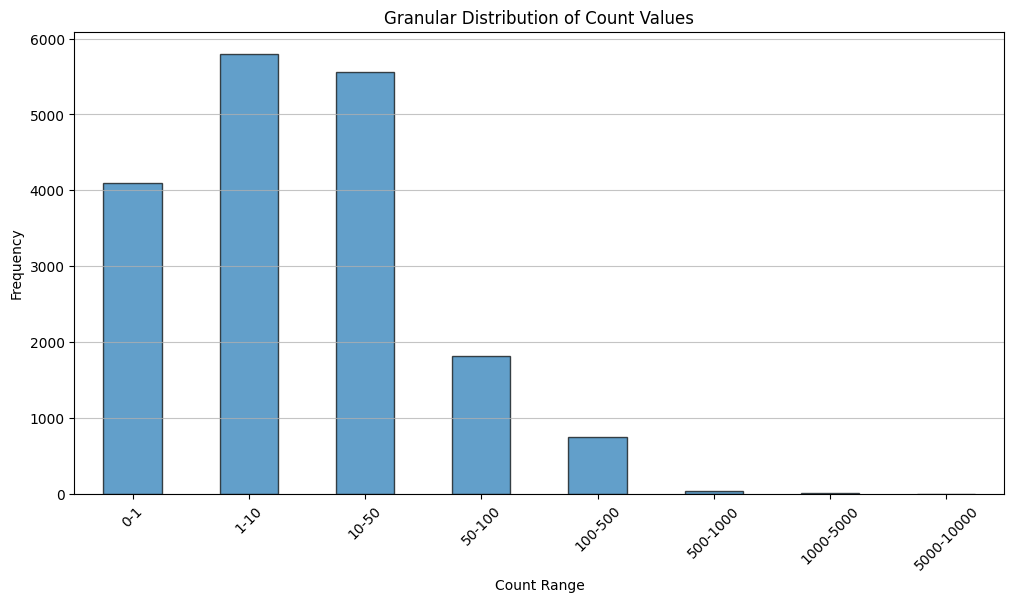

In [27]:
# Creating bins for granular distribution
bins = [0, 1, 10, 50, 100, 500, 1000, 5000, 10000]
labels = ['0-1', '1-10', '10-50', '50-100', '100-500', '500-1000', '1000-5000', '5000-10000']

# Binning the 'Count' column
train_data['Count_Binned'] = pd.cut(train_data['Count'], bins=bins, labels=labels, include_lowest=True)

# Getting the distribution
count_distribution = train_data['Count_Binned'].value_counts().sort_index()

# Plotting the distribution
plt.figure(figsize=(12, 6))
count_distribution.plot(kind='bar', edgecolor='k', alpha=0.7)
plt.title('Granular Distribution of Count Values')
plt.xlabel('Count Range')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.xticks(rotation=45)
plt.show()


In [28]:

# Creating bins for granular distribution
bins = [0, 1, 10, 50, 100, 500, 1000, 5000, 10000]
labels = ['0-1', '1-10', '10-50', '50-100', '100-500', '500-1000', '1000-5000', '5000-10000']

# Filtering non-whole number 'Count' values
non_whole_counts = train_data[~train_data['Count'].isnull() & ~train_data['Count'].apply(float.is_integer)]

# Binning the non-whole number 'Count' values
non_whole_counts['Count_Binned'] = pd.cut(non_whole_counts['Count'], bins=bins, labels=labels, include_lowest=True)

# Getting the distribution of non-whole number 'Count' values
non_whole_count_distribution = non_whole_counts['Count_Binned'].value_counts().sort_index()

# Display the distribution
print(non_whole_count_distribution)

Count_Binned
0-1           0
1-10          0
10-50         0
50-100        0
100-500       0
500-1000      0
1000-5000     0
5000-10000    0
Name: count, dtype: int64


In [29]:
# Calculate the absolute count of records with missing 'Count' values
missing_count_abs = train_data['Count'].isnull().sum()
print(f'Number of records with missing Count values: {missing_count_abs}')

Number of records with missing Count values: 0


In [13]:
# Filter records where 'Count' is missing
missing_count_records = train_data[train_data['Count'].isnull()]

# Check for missing 'Category' and 'Multiplier' in the filtered records
missing_category_count = missing_count_records['Category'].isnull().sum()
missing_multiplier_count = missing_count_records['Multiplier'].isnull().sum()

# Get the total number of records with missing 'Count' value
total_missing_count_records = len(missing_count_records)

print(f'Total number of records with missing Count values: {total_missing_count_records}')
print(f'Number of records with missing Count and missing Category values: {missing_category_count}')
print(f'Number of records with missing Count and missing Multiplier values: {missing_multiplier_count}')

# Validate the hypothesis
if missing_category_count == total_missing_count_records and missing_multiplier_count == total_missing_count_records:
    print("Hypothesis is validated: All records with missing 'Count' also have missing 'Category' and 'Multiplier' values.")
else:
    print("Hypothesis is not validated: Some records with missing 'Count' have 'Category' or 'Multiplier' values.")


Total number of records with missing Count values: 98
Number of records with missing Count and missing Category values: 98
Number of records with missing Count and missing Multiplier values: 98
Hypothesis is validated: All records with missing 'Count' also have missing 'Category' and 'Multiplier' values.


In [20]:
# Impute missing values in 'Count' with 0
train = train_data['Count'].fillna(0, inplace=True)

# Verify the imputation
missing_count_abs = train_data['Count'].isnull().sum()
print(f'Number of records with missing Count values after imputation: {missing_count_abs}')

Number of records with missing Count values after imputation: 0


C:\Users\balaj\AppData\Local\Temp\ipykernel_26560\12009833.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train = train_data['Count'].fillna(0, inplace=True)


In [26]:
# Filtering non-whole number 'Count' values
non_whole_counts = train_data[~train_data['Count'].isnull() & ~train_data['Count'].apply(float.is_integer)]

# Binning the non-whole number 'Count' values
non_whole_counts['Count_Binned'] = pd.cut(non_whole_counts['Count'], bins=bins, labels=labels, include_lowest=True)

# Getting the distribution of non-whole number 'Count' values
non_whole_count_distribution = non_whole_counts['Count_Binned'].value_counts().sort_index()

# Display the distribution
print(non_whole_count_distribution)

Count_Binned
0-1           0
1-10          0
10-50         0
50-100        0
100-500       0
500-1000      0
1000-5000     0
5000-10000    0
Name: count, dtype: int64


In [25]:

# Round off the 'Count' column values to the nearest whole number
train_data['Count'] = train_data['Count'].round()

# Verify the changes
print(train_data['Count'].head())


0     1.0
1     8.0
2    20.0
3     8.0
4    12.0
Name: Count, dtype: float64


In [34]:


# Load the training data
tr_data = pd.read_csv('cvs_wg_pns_train.csv')

# Separate data into records with and without 'Category'
data_with_category = tr_data[tr_data['Category'].notnull()]
data_without_category = tr_data[tr_data['Category'].isnull()]

# Features and target for the prediction model
features = ['Retail_Price', 'Promo_Price', 'Count', 'Multiplier', 'Manufacturer']
target = 'Category'

# One-hot encode categorical features
data_with_category_encoded = pd.get_dummies(data_with_category[features])
data_without_category_encoded = pd.get_dummies(data_without_category[features])

# Ensure both datasets have the same dummy variables
data_with_category_encoded, data_without_category_encoded = data_with_category_encoded.align(data_without_category_encoded, join='left', axis=1, fill_value=0)

# Train a Decision Tree Classifier to predict 'Category'
X = data_with_category_encoded
y = data_with_category[target]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict missing 'Category' values
predicted_categories = clf.predict(data_without_category_encoded)

# Impute the missing values
tr_data.loc[tr_data['Category'].isnull(), 'Category'] = predicted_categories

# Save the imputed dataset to a new CSV file (optional)
tr_data.to_csv('cvs_wg_pns_train_category_imputed.csv', index=False)

# Verify the imputation
missing_category_count = tr_data['Category'].isnull().sum()
print(f'Number of records with missing Category values after imputation: {missing_category_count}')


Number of records with missing Category values after imputation: 0


In [39]:
# Predict and evaluate on the validation set
y_pred_val = clf.predict(X_val)
accuracy = accuracy_score(y_val, y_pred_val)
print(f'Accuracy of the Category prediction model: {accuracy:.2f}')

Accuracy of the Category prediction model: 0.67


In [71]:
# Separate data into records with and without 'Category'
data_with_category = train_data[train_data['Category'].notnull()]
data_without_category = train_data[train_data['Category'].isnull()]

# Features and target for the prediction model
features = ['Retail_Price', 'Promo_Price', 'Count', 'Multiplier', 'Manufacturer']
target = 'Category'

# One-hot encode categorical features
data_with_category_encoded = pd.get_dummies(data_with_category[features])
data_without_category_encoded = pd.get_dummies(data_without_category[features])

# Ensure both datasets have the same dummy variables
data_with_category_encoded, data_without_category_encoded = data_with_category_encoded.align(data_without_category_encoded, join='left', axis=1, fill_value=0)

# Train a Decision Tree Classifier to predict 'Category'
X = data_with_category_encoded
y = data_with_category[target]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict missing 'Category' values
predicted_categories = clf.predict(data_without_category_encoded)

# Predict and evaluate on the validation set
y_pred_val = clf.predict(X_val)
accuracy = accuracy_score(y_val, y_pred_val)
print(f'Accuracy of the Category prediction model: {accuracy:.2f}')

# Impute the missing values
train_data.loc[train_data['Category'].isnull(), 'Category'] = predicted_categories

# Save the imputed dataset to a new CSV file (optional)
train_data.to_csv('cvs_wg_pns_train_category_imputed1.csv', index=False)

# Verify the imputation
missing_category_count = train_data['Category'].isnull().sum()
print(f'Number of records with missing Category values after imputation: {missing_category_count}')

ValueError: Found array with 0 sample(s) (shape=(0, 497)) while a minimum of 1 is required by DecisionTreeClassifier.

In [43]:
# Predict and evaluate on the validation set
y_pred_val = clf.predict(X_val)
accuracy = accuracy_score(y_val, y_pred_val)
print(f'Accuracy of the Category prediction model: {accuracy:.2f}')

Accuracy of the Category prediction model: 0.65


In [44]:

# Load the training data
tr_data = pd.read_csv('cvs_wg_pns_train.csv')

# Check if Retail_Price * Count is equal to Multiplier
tr_data['Calculated_Multiplier'] = tr_data['Retail_Price'] * tr_data['Count']

# Validate the hypothesis
validation_result = tr_data[['Retail_Price', 'Count', 'Multiplier', 'Calculated_Multiplier']].dropna()
validation_result['Matches'] = validation_result['Multiplier'] == validation_result['Calculated_Multiplier']

# Get the count of matches and mismatches
matches = validation_result['Matches'].sum()
total = len(validation_result)
mismatches = total - matches

print(f'Matches: {matches}')
print(f'Mismatches: {mismatches}')
print(f'Total: {total}')

# Display a few mismatched records for inspection
mismatched_records = validation_result[validation_result['Matches'] == False]
print(mismatched_records.head())


Matches: 14725
Mismatches: 3243
Total: 17968
    Retail_Price  Count  Multiplier  Calculated_Multiplier  Matches
10         11.00  16.90    185.9000               185.9000    False
67          8.29   3.00     24.8700                24.8700    False
96         29.99  33.80   1013.6620              1013.6620    False
98         17.99  13.52    243.2248               243.2248    False
99         19.99  30.00    599.7000               599.7000    False


In [46]:
# Write the mismatched records tob a CSV file
mismatched_records.to_csv('mismatched_records.csv', index=False)

In [49]:

# Load the training data
tr_data = pd.read_csv('cvs_wg_pns_train.csv')

# Check if Retail_Price * Count is equal to Multiplier within a tolerance level
tolerance = 0.01
tr_data['Calculated_Multiplier'] = tr_data['Retail_Price'] * tr_data['Count']

# Validate the hypothesis with tolerance
validation_result = tr_data[['Retail_Price', 'Count', 'Multiplier', 'Calculated_Multiplier']].dropna()
validation_result['Matches'] = np.isclose(validation_result['Multiplier'], validation_result['Calculated_Multiplier'], atol=tolerance)

# Get the count of matches and mismatches
matches = validation_result['Matches'].sum()
total = len(validation_result)
mismatches = total - matches

print(f'Matches: {matches}')
print(f'Mismatches: {mismatches}')
print(f'Total: {total}')

# Display a few mismatched records for inspection
mismatched_records = validation_result[validation_result['Matches'] == False]
print(mismatched_records.head())

Matches: 17968
Mismatches: 0
Total: 17968
Empty DataFrame
Columns: [Retail_Price, Count, Multiplier, Calculated_Multiplier, Matches]
Index: []


In [50]:
import pandas as pd
import numpy as np

# Load the training data
test_data = pd.read_csv('cvs_wg_pns_train.csv')

# Calculate the Multiplier by multiplying Retail_Price with Count
test_data['Calculated_Multiplier'] = test_data['Retail_Price'] * test_data['Count']

# Set a tolerance level
tolerance = 0.01

# Validate the Multiplier values with a tolerance level
test_data['Matches'] = np.isclose(test_data['Multiplier'], test_data['Calculated_Multiplier'], atol=tolerance)

# Get the count of matches and mismatches
matches = test_data['Matches'].sum()
total = len(test_data)
mismatches = total - matches

print(f'Matches: {matches}')
print(f'Mismatches: {mismatches}')
print(f'Total: {total}')

# Output mismatched records for inspection
mismatched_records = test_data[test_data['Matches'] == False]
print(mismatched_records.head())


Matches: 17968
Mismatches: 99
Total: 18067
                         Description           UPC  Promo_Price  Retail_Price  \
10671  CERAVE SKN RENEW EXF TM 1.7OZ  3.606000e+11          NaN         29.99   
10690    NATRL INST HC 7A DK CL BLND  3.614230e+11          NaN          9.99   
10698       ABENA SLIP PRM BRF S2 28  5.713570e+11          NaN         94.97   
10764   CERAVE SA RENEW CRM 12OZ R/B  3.606000e+11          NaN         21.99   
10875   CERAVE HYALURNC ACID SRM 1OZ  3.606000e+11          NaN         21.99   

       List_Price Manufacturer Category  Count  Multiplier Retailer  \
10671       17.39       LOREAL      NaN    NaN         NaN      PNS   
10690        5.40         COTY      NaN    NaN         NaN      PNS   
10698       22.61        ABENA      NaN    NaN         NaN      PNS   
10764       16.37       LOREAL      NaN    NaN         NaN      PNS   
10875       13.71       LOREAL      NaN    NaN         NaN      PNS   

       Calculated_Multiplier  Matches  
106

In [51]:
# Save the mismatched records to a CSV file
mismatched_records.to_csv('mismatched_records_multiplier_records.csv', index=False)

In [52]:
# Load the training data
tr_data = pd.read_csv('cvs_wg_pns_train.csv')

# Calculate the number of records with empty or zero 'Count' values
empty_count = tr_data['Count'].isnull().sum()
zero_count = (tr_data['Count'] == 0).sum()
total_empty_or_zero = empty_count + zero_count

print(f'Number of records with empty Count values: {empty_count}')
print(f'Number of records with zero Count values: {zero_count}')
print(f'Total number of records with empty or zero Count values: {total_empty_or_zero}')

Number of records with empty Count values: 98
Number of records with zero Count values: 1
Total number of records with empty or zero Count values: 99


In [61]:

# Impute missing (NaN) 'Count' values with 0
test_data['Count'].fillna(0, inplace=True)

# Ensure zero 'Count' values remain as 0 (already handled by the fillna step)
test_data.loc[test_data['Count'] == 0, 'Count'] = 0

# # Save the imputed dataset to a new CSV file (optional)
# test_data.to_csv('path_to_your_data/cvs_wg_pns_train_imputed.csv', index=False)

# Verify the imputation
empty_count = test_data['Count'].isnull().sum()
zero_count = (test_data['Count'] == 0).sum()
total_empty_or_zero = empty_count + zero_count

print(f'Number of records with empty Count values after imputation: {empty_count}')
print(f'Number of records with zero Count values after imputation: {zero_count}')
print(f'Total number of records with empty or zero Count values after imputation: {total_empty_or_zero}')


Number of records with empty Count values after imputation: 0
Number of records with zero Count values after imputation: 99
Total number of records with empty or zero Count values after imputation: 99


C:\Users\balaj\AppData\Local\Temp\ipykernel_26560\3095401499.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data['Count'].fillna(0, inplace=True)


In [64]:
# Verify the imputation
empty_count = test_data['Count'].isnull().sum()
zero_count = (test_data['Count'] == 0).sum()
total_empty_or_zero = empty_count + zero_count
# print(f'Number of records with empty Count values after imputation: {empty_count}')
# print(f'Number of records with zero Count values after imputation: {zero_count}')
print(f'Total number of records with empty  Count values after imputation: {empty_count}')

Total number of records with empty  Count values after imputation: 0


In [65]:

# Calculate the number of missing values for the Multiplier column before imputation
missing_multiplier_before = test_data['Multiplier'].isnull().sum()

# Calculate the Multiplier for records with missing Multiplier values
test_data['Multiplier'] = np.where(test_data['Multiplier'].isnull(), 
                                   test_data['Retail_Price'] * test_data['Count'], 
                                   test_data['Multiplier'])

# Calculate the number of missing values for the Multiplier column after imputation
missing_multiplier_after = test_data['Multiplier'].isnull().sum()



# # Save the modified dataset to a new CSV file (optional)
# test_data.to_csv('path_to_your_data/cvs_wg_pns_train_with_interactions.csv', index=False)

# Verify the new features
print(test_data[['Retail_Price', 'Count', 'Multiplier', 'Retail_Price_Count', 'Promo_Price_Count', 'Retail_Price_Multiplier', 'Promo_Price_Multiplier']].head())

# Output the number of missing values before and after imputation
print(f'Missing Multiplier values before imputation: {missing_multiplier_before}')
print(f'Missing Multiplier values after imputation: {missing_multiplier_after}')


   Retail_Price  Count  Multiplier  Retail_Price_Count  Promo_Price_Count  \
0         17.99    1.0      17.990              17.990                NaN   
1          8.29    8.0      66.320              66.320               46.4   
2          4.90   20.0      98.000              98.000                NaN   
3          5.99    8.5      50.915              50.915                NaN   
4         18.99   12.0     227.880             227.880                NaN   

   Retail_Price_Multiplier  Promo_Price_Multiplier  
0                323.64010                     NaN  
1                549.79280                 384.656  
2                480.20000                     NaN  
3                304.98085                     NaN  
4               4327.44120                     NaN  
Missing Multiplier values before imputation: 98
Missing Multiplier values after imputation: 0


In [66]:


# Calculate the number of missing values for Multiplier and Count columns after imputation
missing_multiplier_after = test_data['Multiplier'].isnull().sum()
missing_count_after = test_data['Count'].isnull().sum()

# Output the number of missing values before and after imputation

print(f'Missing Multiplier values after imputation: {missing_multiplier_after}')

print(f'Missing Count values after imputation: {missing_count_after}')

Missing Multiplier values after imputation: 0
Missing Count values after imputation: 0


In [77]:
# Identify columns with missing values
missing_values_summary = test_data.isnull().sum()

# Filter out columns with no missing values
columns_with_missing_values = missing_values_summary[missing_values_summary > 0]

# Print the columns with missing values and their counts
print(columns_with_missing_values)

Promo_Price    15046
Category          98
dtype: int64


In [108]:

# # Identify columns with missing values
# missing_values_summary = test_data.isnull().sum()
# missing_values_summary1 = test_data.info()

# # Filter out columns with no missing values
# columns_with_missing_values = missing_values_summary[missing_values_summary > 0]

# # Print the columns with missing values and their counts
# print(columns_with_missing_values)
# print(missing_values_summary1)
test_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18067 entries, 0 to 18066
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Description   18067 non-null  object 
 1   UPC           18067 non-null  float64
 2   Promo_Price   18067 non-null  float64
 3   Retail_Price  18067 non-null  float64
 4   List_Price    18067 non-null  float64
 5   Manufacturer  18067 non-null  object 
 6   Category      18067 non-null  object 
 7   Count         18067 non-null  float64
 8   Multiplier    18067 non-null  float64
 9   Retailer      18067 non-null  object 
 10  Matches       18067 non-null  bool   
dtypes: bool(1), float64(6), object(4)
memory usage: 1.4+ MB


In [91]:


# Separate data into records with and without 'Category'
data_with_category = test_data[test_data['Category'].notnull()]
data_without_category = test_data[test_data['Category'].isnull()]

# Count the number of records in each subset
count_with_category = data_with_category.shape[0]
count_without_category = data_without_category.shape[0]

# Print the counts
print(f'Number of records with Category: {count_with_category}')
print(f'Number of records without Category: {count_without_category}')


Number of records with Category: 18067
Number of records without Category: 0


In [85]:

# Check for missing values in 'Category'
missing_category_count = train_data['Category'].isnull().sum()
print(f'Number of records with missing Category values: {missing_category_count}')

# If missing values exist, proceed with imputation
if missing_category_count > 0:
    # Separate data into records with and without 'Category'
    data_with_category = train_data[train_data['Category'].notnull()]
    data_without_category = train_data[train_data['Category'].isnull()]

    # Print the counts of records with and without 'Category'
    print(f'Number of records with Category: {data_with_category.shape[0]}')
    print(f'Number of records without Category: {data_without_category.shape[0]}')

    # Features and target for the prediction model
    features = ['Retail_Price', 'Promo_Price', 'Count', 'Multiplier', 'Manufacturer']
    target = 'Category'

    # One-hot encode categorical features
    data_with_category_encoded = pd.get_dummies(data_with_category[features])
    data_without_category_encoded = pd.get_dummies(data_without_category[features])

    # Ensure both datasets have the same dummy variables
    data_with_category_encoded, data_without_category_encoded = data_with_category_encoded.align(data_without_category_encoded, join='left', axis=1, fill_value=0)

    # Print the shapes of the encoded DataFrames
    print(f'Shape of data_with_category_encoded before alignment: {data_with_category_encoded.shape}')
    print(f'Shape of data_without_category_encoded before alignment: {data_without_category_encoded.shape}')
    print(f'Shape of data_with_category_encoded after alignment: {data_with_category_encoded.shape}')
    print(f'Shape of data_without_category_encoded after alignment: {data_without_category_encoded.shape}')

    # Train a Decision Tree Classifier to predict 'Category'
    X = data_with_category_encoded
    y = data_with_category[target]
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, y_train)

    # Predict missing 'Category' values
    predicted_categories = clf.predict(data_without_category_encoded)

    # Predict and evaluate on the validation set
    y_pred_val = clf.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred_val)
    print(f'Accuracy of the Category prediction model: {accuracy:.2f}')

    # Impute the missing values
    train_data.loc[train_data['Category'].isnull(), 'Category'] = predicted_categories

    # Save the imputed dataset to a new CSV file (optional)
    train_data.to_csv('path_to_your_data/cvs_wg_pns_train_category_imputed.csv', index=False)

    # Verify the imputation
    missing_category_count = train_data['Category'].isnull().sum()
    print(f'Number of records with missing Category values after imputation: {missing_category_count}')
else:
    print("No missing values in 'Category' column.")


Number of records with missing Category values: 0
No missing values in 'Category' column.


In [90]:
# Calculate the mode of the 'Category' column
mode_category = test_data['Category'].mode()[0]

# Impute missing values in 'Category' with the mode
test_data['Category'].fillna(mode_category, inplace=True)

C:\Users\balaj\AppData\Local\Temp\ipykernel_26560\3735412229.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data['Category'].fillna(mode_category, inplace=True)


In [107]:


# # Load the training data
# test_data = pd.read_csv('path_to_your_data/cvs_wg_pns_train.csv')

# Separate data into records with and without 'Promo_Price'
data_with_promo_price = test_data[test_data['Promo_Price'].notnull()]
data_without_promo_price = test_data[test_data['Promo_Price'].isnull()]

# Features and target for the prediction model
features = ['Retail_Price', 'Count', 'Multiplier', 'Manufacturer', 'Category']
target = 'Promo_Price'

# One-hot encode categorical features
data_with_promo_price_encoded = pd.get_dummies(data_with_promo_price[features])

# Train a Random Forest Regressor to predict 'Promo_Price'
X = data_with_promo_price_encoded
y = data_with_promo_price[target]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

regressor = RandomForestRegressor(random_state=42)
regressor.fit(X_train, y_train)

# Predict on the validation set
y_pred_val = regressor.predict(X_val)

# Calculate evaluation metrics
mae = mean_absolute_error(y_val, y_pred_val)
mse = mean_squared_error(y_val, y_pred_val)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

# Predict missing 'Promo_Price' values
data_without_promo_price_encoded = pd.get_dummies(data_without_promo_price[features])
data_without_promo_price_encoded = data_without_promo_price_encoded.reindex(columns=data_with_promo_price_encoded.columns, fill_value=0)
predicted_promo_prices = regressor.predict(data_without_promo_price_encoded)

# Impute the missing values
test_data.loc[test_data['Promo_Price'].isnull(), 'Promo_Price'] = predicted_promo_prices

# # Save the imputed dataset to a new CSV file (optional)
# test_data.to_csv('path_to_your_data/cvs_wg_pns_train_promo_price_imputed_model.csv', index=False)

# Verify the imputation
missing_promo_price_count = test_data['Promo_Price'].isnull().sum()
print(f'Number of records with missing Promo_Price values after imputation: {missing_promo_price_count}')


Mean Absolute Error (MAE): 0.90
Mean Squared Error (MSE): 4.38
Root Mean Squared Error (RMSE): 2.09
Number of records with missing Promo_Price values after imputation: 0


In [112]:
import pandas as pd

# Prepare the data
features = ['Retail_Price', 'Promo_Price', 'Count', 'Multiplier', 'Manufacturer', 'Category']
target = 'List_Price'

# One-hot encode categorical features
test_data_encoded = pd.get_dummies(test_data[features])

# Separate features and target variable
X = test_data_encoded
y = test_data[target]

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Regressor
regressor = RandomForestRegressor(random_state=42)
regressor.fit(X_train, y_train)

# Predict on the validation set
y_pred_val = regressor.predict(X_val)

# Calculate evaluation metrics
mae = mean_absolute_error(y_val, y_pred_val)
mse = mean_squared_error(y_val, y_pred_val)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred_val)

print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'R-squared (R2 ): {r2:.2f}')

# Optionally, save the trained model
import joblib
joblib.dump(regressor, 'random_forest_model.joblib')

# Save the predictions along with validation data to a new CSV file (optional)
validation_results = X_val.copy()
validation_results['Actual_List_Price'] = y_val
validation_results['Predicted_List_Price'] = y_pred_val
# validation_results.to_csv('path_to_your_data/validation_results.csv', index=False)


Mean Absolute Error (MAE): 0.92
Mean Squared Error (MSE): 3.38
Root Mean Squared Error (RMSE): 1.84
R-squared (R2 ): 0.96


OSError: Cannot save file into a non-existent directory: 'path_to_your_data'


# Separate features and target variable
X = train_data.drop(columns=['List_Price', 'Description', 'UPC', 'Retailer'])
y = train_data['List_Price']

# Define categorical and numerical features
categorical_features = ['Manufacturer', 'Category']
numerical_features = ['Retail_Price', 'Promo_Price', 'Count', 'Multiplier']

# Preprocessing pipeline for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Define the model pipeline with Random Forest
model_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

print(numerical_features)



# Define parameter grid for Grid Search
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)




# Perform Grid Search
grid_search = GridSearchCV(model_rf, param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')



# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters from Grid Search
best_params = grid_search.best_params_
print(f'Best parameters from Grid Search: {best_params}')


# Predict and evaluate the model
y_pred_rf = grid_search.predict(X_val)
mse_rf = mean_squared_error(y_val, y_pred_rf)
print(f'Mean Squared Error on validation set: {mse_rf:.2f}')



# Preprocess the testing data
test_data['Promo_Price'].fillna(test_data['Retail_Price'], inplace=True)
test_data['Category'].fillna(most_frequent_category, inplace=True)
test_data['Count'].fillna(0, inplace=True)
test_data['Multiplier'].fillna(0, inplace=True)

# Ensure the testing data has the same columns as the training data
X_test = test_data[X.columns]

# Predict the list prices
predictions = grid_search.predict(X_test)



# Save the predictions
test_data['Predicted_List_Price'] = predictions
test_data.to_csv('predictions_rf.csv', index=False)
print("Predictions saved to 'predictions_rf.csv'")

# Predict and evaluate the model
y_pred_rf = grid_search.predict(X_val)
mse_rf = mean_squared_error(y_val, y_pred_rf)
print(f'Mean Squared Error on validation set: {mse_rf:.2f}')



from xgboost import XGBRegressor

# Define the model pipeline with XGBoost
model_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(random_state=42))
])

# Define parameter grid for Grid Search
param_grid_xgb = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [3, 6, 10],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__subsample': [0.7, 0.8, 1.0]
}



# Perform Grid Search
grid_search_xgb = GridSearchCV(model_xgb, param_grid_xgb, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search_xgb.fit(X_train, y_train)

# Best parameters from Grid Search
best_params_xgb = grid_search_xgb.best_params_
print(f'Best parameters from Grid Search: {best_params_xgb}')




# Predict and evaluate the model
y_pred_xgb = grid_search_xgb.predict(X_val)
mse_xgb = mean_squared_error(y_val, y_pred_xgb)
print(f'Mean Squared Error on validation set: {mse_xgb:.2f}')

# # Preprocess the testing data
# test_data['Promo_Price'].fillna(test_data['Retail_Price'], inplace=True)
# test_data['Category'].fillna(most_frequent_category, inplace=True)
# test_data['Count'].fillna(0, inplace=True)
# test_data['Multiplier'].fillna(0, inplace=True)

# # Ensure the testing data has the same columns as the training data
# X_test = test_data[X.columns]

# # Predict the list prices
# predictions_xgb = grid_search_xgb.predict(X_test)

# # Save the predictions
# test_data['Predicted_List_Price'] = predictions_xgb
# test_data.to_csv('predictions_xgb.csv', index=False)
# print("Predictions saved to 'predictions_xgb.csv'")